# Free-form injective flow with moons manifold

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from tqdm.auto import trange
from sklearn.datasets import make_moons

from ciflows.loss import volume_change_surrogate

import matplotlib.pyplot as plt

/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from torch.autograd import grad
from torch.autograd.forward_ad import dual_level, make_dual, unpack_dual
from collections import namedtuple
from math import sqrt, prod

SurrogateOutput = namedtuple(
    "SurrogateOutput", ["surrogate", "z", "x1", "regularizations"]
)


def sample_v(
    x: torch.Tensor, hutchinson_samples: int, manifold= None
) -> torch.Tensor:
    """
    Sample a random vector v of shape (*x.shape, hutchinson_samples)
    with scaled orthonormal columns.

    The reference data is used for shape, device and dtype.

    :param x: Reference data. Shape: (batch_size, ...).
    :param hutchinson_samples: Number of Hutchinson samples to draw.
    :param manifold: Optional manifold on which the data lies. If provided,
        the vectors are sampled in the tangent space of the manifold.
    :return: Random vectors of shape (batch_size, ...)
    """
    batch_size, total_dim = x.shape[0], prod(x.shape[1:])

    if hutchinson_samples > total_dim:
        raise ValueError(
            f"Too many Hutchinson samples: got {hutchinson_samples}, \
                expected <= {total_dim}"
        )
    # M-FFF: More than one Hutchinson sample not implemented for M-FFF
    if manifold is not None and hutchinson_samples != 1:
        raise NotImplementedError(
            f"More than one Hutchinson sample not implemented for M-FFF, \
                {hutchinson_samples} requested."
        )

    if manifold is None:
        v = torch.randn(
            batch_size, total_dim, hutchinson_samples, device=x.device, dtype=x.dtype
        )
        q = torch.linalg.qr(v).Q.reshape(*x.shape, hutchinson_samples)
        return q * sqrt(total_dim)
    # M-FFF: Sample v in the tangent space of the manifold at x
    # else:
    #     v = random_tangent_vec(manifold, x.detach(), n_samples=batch_size)
    #     v /= torch.norm(v, p=2, dim=list(range(1, len(v.shape))), keepdim=True)
    #     return v[..., None] * sqrt(total_dim)




def reconstruction_loss(
    a: torch.Tensor, b: torch.Tensor
) -> torch.Tensor:
    return torch.sum((a - b) ** 2, dim=tuple(range(1, len(a.shape))))


def sum_except_batch(x: torch.Tensor) -> torch.Tensor:
    """Sum over all dimensions except the first.
    :param x: Input tensor. Shape: (batch_size, ...)
    :return: Sum over all dimensions except the first. Shape: (batch_size,)
    """
    return torch.sum(x.reshape(x.shape[0], -1), dim=1)



def volume_change_surrogate_fff(
    x: torch.Tensor,
    encode,
    decode,
    hutchinson_samples: int = 1,
    manifold = None,
) -> SurrogateOutput:
    r"""Computes the surrogate for the volume change term in the change of
    variables formula. The surrogate is given by:
    $$
    v^T f_\theta'(x) \texttt{SG}(g_\phi'(z) v).
    $$
    The gradient of the surrogate is the gradient of the volume change term.

    :param x: Input data. Shape: (batch_size, ...)
    :param encode: Encoder function. Takes `x` as input and returns a latent
        representation `z` of shape (batch_size, latent_shape).
    :param decode: Decoder function. Takes a latent representation `z` as input
        and returns a reconstruction `x1`.
    :param hutchinson_samples: Number of Hutchinson samples to use for the
        volume change estimator. The number of hutchinson samples must be less
        than or equal to the total dimension of the data.
    :param manifold: Manifold on which the latent space lies. If provided, the
        volume change is computed in the tangent space of the manifold.
    :return: The computed surrogate of shape (batch_size,), latent representation
        `z`, reconstruction `x1` and regularization metrics computed on the fly.
    """
    regularizations = {}
    surrogate = 0

    x.requires_grad_()
    z = encode(x)

    # M-FFF: Project to manifold and store projection distance for
    # regularization
    if manifold is not None:
        z_projected = manifold.projection(z)
        regularizations["z_projection"] = reconstruction_loss(z, z_projected)
        z = z_projected

    vs = sample_v(z, hutchinson_samples, manifold)

    for k in range(hutchinson_samples):
        v = vs[..., k]

        # $ g'(z) v $ via forward-mode AD
        with dual_level():
            dual_z = make_dual(z, v)
            dual_x1 = decode(dual_z)

            # M-FFF: Project to manifold and store projection distance for
            # regularization
            if manifold is not None:
                dual_x1_projected = manifold.projection(dual_x1)
                regularizations["x1_projection"] = reconstruction_loss(
                    unpack_dual(dual_x1_projected)[0], unpack_dual(dual_x1)[0]
                )
                dual_x1 = dual_x1_projected

            x1, v1 = unpack_dual(dual_x1)

        # $ v^T f'(x) $ via backward-mode AD
        (v2,) = grad(z, x, v, create_graph=True)

        # $ v^T f'(x) stop_grad(g'(z)) v $
        surrogate += sum_except_batch(v2 * v1.detach()) / hutchinson_samples

    return SurrogateOutput(surrogate, z, x1, regularizations)


In [5]:
dim = 2
latent_dim = dim  # The code below also works for latent_dim < dim
hidden_dim = 128
n_steps = 10000

noise = 0.1

beta = 100
batch_size = 1024
device = "cpu"


class SkipConnection(torch.nn.Module):
    def __init__(self, inner):
        super().__init__()
        self.inner = inner

    def forward(self, x, *args, **kwargs):
        return x + self.inner(x, *args, **kwargs)


# Do not use ReLU below, makes training unstable
encoder = SkipConnection(torch.nn.Sequential(
    torch.nn.Linear(dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, latent_dim)
).to(device))
decoder = SkipConnection(torch.nn.Sequential(
    torch.nn.Linear(latent_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, dim)
).to(device))

latent = torch.distributions.Independent(
    torch.distributions.Normal(
        loc=torch.zeros(latent_dim, device=device),
        scale=torch.ones(latent_dim, device=device),
    ),
    1
)

In [11]:

optim = torch.optim.Adam([*encoder.parameters(), *decoder.parameters()], lr=3e-4)

with trange(n_steps) as pbar:
    for step in pbar:
        optim.zero_grad()
        batch, _ = make_moons(batch_size, noise=noise)
        x = torch.from_numpy(batch).float().to(device)
        
        surrogate_loss, v, xhat = volume_change_surrogate(
            x, encoder, decoder, hutchinson_samples=1
        )
        # loss_reconstruction = ((x - xhat) ** 2).sum(-1)
        loss_nll = -latent.log_prob(v) - surrogate_loss

        loss_reconstruction = torch.nn.functional.mse_loss(x, xhat)
        # print(loss_mse, loss_reconstruction.mean())
        # assert False
        # surrogate = volume_change_surrogate_fff(
        #     x, encoder, decoder, hutchinson_samples=1
        # )
        # loss_reconstruction_fff = ((x - surrogate.x1) ** 2).sum(-1)#.mean(-1)
        # loss_nll_fff = -latent.log_prob(surrogate.z) - surrogate.surrogate

        # assert torch.allclose(loss_reconstruction, loss_reconstruction_fff)
        # assert torch.allclose(surrogate_loss, surrogate.surrogate)
        # assert torch.allclose(loss_nll.mean(), loss_nll_fff.mean())

        loss = beta * loss_reconstruction + loss_nll
        loss.mean().backward()
        optim.step()

        if step % 100 == 0:
            print(f"Reconstruction: {loss_reconstruction.mean():.1e}, NLL: {loss_nll.mean():.2f}, surrogate: {surrogate_loss.mean():.2f}")
            pbar.set_description(f"Reconstruction: {loss_reconstruction.mean():.1e}, NLL: {loss_nll.mean():.2f}")
        #     with torch.no_grad():
        #         batch, _ = make_moons(batch_size, noise=noise)
        #         x = torch.from_numpy(batch).float().to(device)
        #         # surrogate_loss, v, xhat =  volume_change_surrogate(x, encoder, decoder, hutchinson_samples=1)
        #         # nll_out = -latent.log_prob(latent.sample((batch_size,))) - surrogate_loss
        #         # reconstruction = ((x - xhat) ** 2).sum(-1).mean(-1)

        #         surrogate = volume_change_surrogate(
        #             x, encoder, decoder, hutchinson_samples=1
        #         )
        #         loss_reconstruction = ((x - surrogate.x1) ** 2).sum(-1).mean(-1)
        #         loss_nll = -latent.log_prob(latent.sample((batch_size,))) - surrogate.surrogate
                
        #         pbar.set_description(f"Reconstruction: {loss_reconstruction:.1e}, NLL: {loss_nll.mean():.2f}")

Reconstruction: 3.0e-04, NLL: 0.85:   0%|          | 13/10000 [00:00<02:49, 58.91it/s]

Reconstruction: 3.0e-04, NLL: 0.85, surrogate: 2.06


Reconstruction: 2.1e-04, NLL: 0.77:   1%|          | 109/10000 [00:01<02:31, 65.27it/s]

Reconstruction: 2.1e-04, NLL: 0.77, surrogate: 2.11


Reconstruction: 3.8e-04, NLL: 0.81:   2%|▏         | 214/10000 [00:03<02:28, 66.00it/s]

Reconstruction: 3.8e-04, NLL: 0.81, surrogate: 2.06


Reconstruction: 2.6e-04, NLL: 0.76:   3%|▎         | 312/10000 [00:04<02:28, 65.07it/s]

Reconstruction: 2.6e-04, NLL: 0.76, surrogate: 2.11


Reconstruction: 4.6e-04, NLL: 0.80:   4%|▍         | 410/10000 [00:06<02:26, 65.31it/s]

Reconstruction: 4.6e-04, NLL: 0.80, surrogate: 2.08


Reconstruction: 3.3e-04, NLL: 0.86:   5%|▌         | 508/10000 [00:07<02:32, 62.36it/s]

Reconstruction: 3.3e-04, NLL: 0.86, surrogate: 2.03


Reconstruction: 3.6e-04, NLL: 0.77:   6%|▌         | 613/10000 [00:09<02:22, 65.95it/s]

Reconstruction: 3.6e-04, NLL: 0.77, surrogate: 2.12


Reconstruction: 2.8e-04, NLL: 0.81:   7%|▋         | 711/10000 [00:11<02:24, 64.38it/s]

Reconstruction: 2.8e-04, NLL: 0.81, surrogate: 2.06


Reconstruction: 3.8e-04, NLL: 0.85:   8%|▊         | 809/10000 [00:12<02:18, 66.32it/s]

Reconstruction: 3.8e-04, NLL: 0.85, surrogate: 2.08


Reconstruction: 4.1e-04, NLL: 0.80:   9%|▉         | 914/10000 [00:14<02:16, 66.40it/s]

Reconstruction: 4.1e-04, NLL: 0.80, surrogate: 2.09


Reconstruction: 5.5e-04, NLL: 0.77:  10%|█         | 1012/10000 [00:15<02:15, 66.16it/s]

Reconstruction: 5.5e-04, NLL: 0.77, surrogate: 2.11


Reconstruction: 3.6e-04, NLL: 0.76:  11%|█         | 1110/10000 [00:17<02:13, 66.45it/s]

Reconstruction: 3.6e-04, NLL: 0.76, surrogate: 2.10


Reconstruction: 4.0e-04, NLL: 0.83:  12%|█▏        | 1208/10000 [00:18<02:12, 66.33it/s]

Reconstruction: 4.0e-04, NLL: 0.83, surrogate: 2.07


Reconstruction: 7.1e-04, NLL: 0.86:  13%|█▎        | 1313/10000 [00:20<02:10, 66.71it/s]

Reconstruction: 7.1e-04, NLL: 0.86, surrogate: 2.04


Reconstruction: 3.5e-04, NLL: 0.82:  14%|█▍        | 1411/10000 [00:21<02:09, 66.43it/s]

Reconstruction: 3.5e-04, NLL: 0.82, surrogate: 2.08


Reconstruction: 4.1e-04, NLL: 0.81:  15%|█▌        | 1509/10000 [00:23<02:07, 66.35it/s]

Reconstruction: 4.1e-04, NLL: 0.81, surrogate: 2.07


Reconstruction: 3.3e-04, NLL: 0.77:  16%|█▌        | 1614/10000 [00:24<02:06, 66.07it/s]

Reconstruction: 3.3e-04, NLL: 0.77, surrogate: 2.09


Reconstruction: 3.7e-04, NLL: 0.77:  17%|█▋        | 1712/10000 [00:26<02:05, 66.17it/s]

Reconstruction: 3.7e-04, NLL: 0.77, surrogate: 2.09


Reconstruction: 4.7e-04, NLL: 0.84:  18%|█▊        | 1810/10000 [00:27<02:03, 66.11it/s]

Reconstruction: 4.7e-04, NLL: 0.84, surrogate: 2.04


Reconstruction: 7.6e-04, NLL: 0.77:  19%|█▉        | 1908/10000 [00:29<02:02, 66.29it/s]

Reconstruction: 7.6e-04, NLL: 0.77, surrogate: 2.09


Reconstruction: 2.8e-04, NLL: 0.75:  20%|██        | 2013/10000 [00:30<02:01, 65.70it/s]

Reconstruction: 2.8e-04, NLL: 0.75, surrogate: 2.11


Reconstruction: 3.7e-04, NLL: 0.81:  21%|██        | 2111/10000 [00:32<02:04, 63.22it/s]

Reconstruction: 3.7e-04, NLL: 0.81, surrogate: 2.07


Reconstruction: 4.4e-04, NLL: 0.76:  22%|██▏       | 2209/10000 [00:33<01:58, 65.98it/s]

Reconstruction: 4.4e-04, NLL: 0.76, surrogate: 2.09


Reconstruction: 4.3e-04, NLL: 0.76:  23%|██▎       | 2314/10000 [00:35<01:56, 65.76it/s]

Reconstruction: 4.3e-04, NLL: 0.76, surrogate: 2.09


Reconstruction: 4.4e-04, NLL: 0.82:  24%|██▍       | 2412/10000 [00:37<01:54, 66.02it/s]

Reconstruction: 4.4e-04, NLL: 0.82, surrogate: 2.08


Reconstruction: 3.0e-04, NLL: 0.75:  25%|██▌       | 2510/10000 [00:38<01:53, 65.90it/s]

Reconstruction: 3.0e-04, NLL: 0.75, surrogate: 2.10


Reconstruction: 6.3e-04, NLL: 0.76:  26%|██▌       | 2608/10000 [00:40<01:51, 66.19it/s]

Reconstruction: 6.3e-04, NLL: 0.76, surrogate: 2.09


Reconstruction: 4.7e-04, NLL: 0.78:  27%|██▋       | 2713/10000 [00:41<01:50, 66.14it/s]

Reconstruction: 4.7e-04, NLL: 0.78, surrogate: 2.09


Reconstruction: 4.1e-04, NLL: 0.83:  28%|██▊       | 2811/10000 [00:43<01:48, 66.16it/s]

Reconstruction: 4.1e-04, NLL: 0.83, surrogate: 2.07


Reconstruction: 3.8e-04, NLL: 0.76:  29%|██▉       | 2909/10000 [00:44<01:49, 64.99it/s]

Reconstruction: 3.8e-04, NLL: 0.76, surrogate: 2.11


Reconstruction: 3.6e-04, NLL: 0.79:  30%|███       | 3014/10000 [00:46<01:45, 66.08it/s]

Reconstruction: 3.6e-04, NLL: 0.79, surrogate: 2.10


Reconstruction: 4.9e-04, NLL: 0.81:  31%|███       | 3112/10000 [00:47<01:44, 66.21it/s]

Reconstruction: 4.9e-04, NLL: 0.81, surrogate: 2.11


Reconstruction: 4.9e-04, NLL: 0.88:  32%|███▏      | 3210/10000 [00:49<01:42, 66.16it/s]

Reconstruction: 4.9e-04, NLL: 0.88, surrogate: 2.00


Reconstruction: 5.1e-04, NLL: 0.81:  33%|███▎      | 3308/10000 [00:50<01:41, 66.12it/s]

Reconstruction: 5.1e-04, NLL: 0.81, surrogate: 2.07


Reconstruction: 3.4e-04, NLL: 0.81:  34%|███▍      | 3413/10000 [00:52<01:39, 66.10it/s]

Reconstruction: 3.4e-04, NLL: 0.81, surrogate: 2.06


Reconstruction: 4.1e-04, NLL: 0.90:  35%|███▌      | 3511/10000 [00:53<01:44, 62.30it/s]

Reconstruction: 4.1e-04, NLL: 0.90, surrogate: 2.01


Reconstruction: 4.4e-04, NLL: 0.79:  36%|███▌      | 3609/10000 [00:55<01:36, 66.03it/s]

Reconstruction: 4.4e-04, NLL: 0.79, surrogate: 2.06


Reconstruction: 5.3e-04, NLL: 0.84:  37%|███▋      | 3714/10000 [00:56<01:35, 66.03it/s]

Reconstruction: 5.3e-04, NLL: 0.84, surrogate: 2.04


Reconstruction: 3.8e-04, NLL: 0.75:  38%|███▊      | 3812/10000 [00:58<01:33, 65.92it/s]

Reconstruction: 3.8e-04, NLL: 0.75, surrogate: 2.13


Reconstruction: 3.9e-04, NLL: 0.80:  39%|███▉      | 3910/10000 [00:59<01:32, 65.88it/s]

Reconstruction: 3.9e-04, NLL: 0.80, surrogate: 2.07


Reconstruction: 3.3e-04, NLL: 0.80:  40%|████      | 4008/10000 [01:01<01:30, 66.09it/s]

Reconstruction: 3.3e-04, NLL: 0.80, surrogate: 2.08


Reconstruction: 5.0e-04, NLL: 0.77:  41%|████      | 4113/10000 [01:03<01:29, 65.95it/s]

Reconstruction: 5.0e-04, NLL: 0.77, surrogate: 2.12


Reconstruction: 4.7e-04, NLL: 0.78:  42%|████▏     | 4211/10000 [01:04<01:28, 65.54it/s]

Reconstruction: 4.7e-04, NLL: 0.78, surrogate: 2.12


Reconstruction: 3.8e-04, NLL: 0.83:  43%|████▎     | 4309/10000 [01:06<01:26, 65.80it/s]

Reconstruction: 3.8e-04, NLL: 0.83, surrogate: 2.03


Reconstruction: 6.1e-04, NLL: 0.78:  44%|████▍     | 4414/10000 [01:07<01:24, 66.00it/s]

Reconstruction: 6.1e-04, NLL: 0.78, surrogate: 2.10


Reconstruction: 4.5e-04, NLL: 0.78:  45%|████▌     | 4512/10000 [01:09<01:23, 65.90it/s]

Reconstruction: 4.5e-04, NLL: 0.78, surrogate: 2.10


Reconstruction: 3.0e-04, NLL: 0.80:  46%|████▌     | 4610/10000 [01:10<01:21, 66.06it/s]

Reconstruction: 3.0e-04, NLL: 0.80, surrogate: 2.08


Reconstruction: 4.8e-04, NLL: 0.80:  47%|████▋     | 4708/10000 [01:12<01:20, 65.96it/s]

Reconstruction: 4.8e-04, NLL: 0.80, surrogate: 2.09


Reconstruction: 5.3e-04, NLL: 0.77:  48%|████▊     | 4813/10000 [01:13<01:18, 66.21it/s]

Reconstruction: 5.3e-04, NLL: 0.77, surrogate: 2.13


Reconstruction: 5.2e-04, NLL: 0.79:  49%|████▉     | 4911/10000 [01:15<01:22, 62.01it/s]

Reconstruction: 5.2e-04, NLL: 0.79, surrogate: 2.08


Reconstruction: 3.6e-04, NLL: 0.76:  50%|█████     | 5009/10000 [01:16<01:15, 66.24it/s]

Reconstruction: 3.6e-04, NLL: 0.76, surrogate: 2.10


Reconstruction: 4.0e-04, NLL: 0.75:  51%|█████     | 5114/10000 [01:18<01:13, 66.28it/s]

Reconstruction: 4.0e-04, NLL: 0.75, surrogate: 2.15


Reconstruction: 3.7e-04, NLL: 0.82:  52%|█████▏    | 5212/10000 [01:19<01:12, 65.77it/s]

Reconstruction: 3.7e-04, NLL: 0.82, surrogate: 2.09


Reconstruction: 4.2e-04, NLL: 0.76:  53%|█████▎    | 5310/10000 [01:21<01:11, 66.01it/s]

Reconstruction: 4.2e-04, NLL: 0.76, surrogate: 2.09


Reconstruction: 4.9e-04, NLL: 0.81:  54%|█████▍    | 5408/10000 [01:22<01:09, 66.31it/s]

Reconstruction: 4.9e-04, NLL: 0.81, surrogate: 2.08


Reconstruction: 3.7e-04, NLL: 0.81:  55%|█████▌    | 5513/10000 [01:24<01:07, 66.08it/s]

Reconstruction: 3.7e-04, NLL: 0.81, surrogate: 2.08


Reconstruction: 4.2e-04, NLL: 0.79:  56%|█████▌    | 5611/10000 [01:25<01:06, 65.81it/s]

Reconstruction: 4.2e-04, NLL: 0.79, surrogate: 2.08


Reconstruction: 5.3e-04, NLL: 0.76:  57%|█████▋    | 5709/10000 [01:27<01:05, 65.96it/s]

Reconstruction: 5.3e-04, NLL: 0.76, surrogate: 2.11


Reconstruction: 5.6e-04, NLL: 0.84:  58%|█████▊    | 5814/10000 [01:29<01:03, 66.04it/s]

Reconstruction: 5.6e-04, NLL: 0.84, surrogate: 2.08


Reconstruction: 3.9e-04, NLL: 0.84:  59%|█████▉    | 5912/10000 [01:30<01:01, 66.22it/s]

Reconstruction: 3.9e-04, NLL: 0.84, surrogate: 2.08


Reconstruction: 6.4e-04, NLL: 0.82:  60%|██████    | 6010/10000 [01:32<01:00, 66.05it/s]

Reconstruction: 6.4e-04, NLL: 0.82, surrogate: 2.06


Reconstruction: 5.3e-04, NLL: 0.78:  61%|██████    | 6108/10000 [01:33<01:00, 64.35it/s]

Reconstruction: 5.3e-04, NLL: 0.78, surrogate: 2.11


Reconstruction: 4.8e-04, NLL: 0.75:  62%|██████▏   | 6213/10000 [01:35<00:58, 64.79it/s]

Reconstruction: 4.8e-04, NLL: 0.75, surrogate: 2.14


Reconstruction: 8.0e-04, NLL: 0.80:  63%|██████▎   | 6311/10000 [01:36<01:01, 60.02it/s]

Reconstruction: 8.0e-04, NLL: 0.80, surrogate: 2.08


Reconstruction: 4.5e-04, NLL: 0.79:  64%|██████▍   | 6409/10000 [01:38<00:56, 64.07it/s]

Reconstruction: 4.5e-04, NLL: 0.79, surrogate: 2.09


Reconstruction: 4.7e-04, NLL: 0.81:  65%|██████▌   | 6508/10000 [01:39<00:53, 64.90it/s]

Reconstruction: 4.7e-04, NLL: 0.81, surrogate: 2.06


Reconstruction: 6.3e-04, NLL: 0.77:  66%|██████▌   | 6612/10000 [01:41<00:59, 56.99it/s]

Reconstruction: 6.3e-04, NLL: 0.77, surrogate: 2.10


Reconstruction: 3.1e-04, NLL: 0.82:  67%|██████▋   | 6710/10000 [01:43<00:51, 64.42it/s]

Reconstruction: 3.1e-04, NLL: 0.82, surrogate: 2.03


Reconstruction: 2.8e-04, NLL: 0.73:  68%|██████▊   | 6808/10000 [01:44<00:49, 64.40it/s]

Reconstruction: 2.8e-04, NLL: 0.73, surrogate: 2.14


Reconstruction: 4.7e-04, NLL: 0.77:  69%|██████▉   | 6913/10000 [01:46<00:48, 63.59it/s]

Reconstruction: 4.7e-04, NLL: 0.77, surrogate: 2.08


Reconstruction: 4.8e-04, NLL: 0.82:  70%|███████   | 7010/10000 [01:47<00:48, 61.33it/s]

Reconstruction: 4.8e-04, NLL: 0.82, surrogate: 2.04


Reconstruction: 4.4e-04, NLL: 0.78:  71%|███████   | 7113/10000 [01:49<00:47, 60.28it/s]

Reconstruction: 4.4e-04, NLL: 0.78, surrogate: 2.12


Reconstruction: 4.3e-04, NLL: 0.85:  72%|███████▏  | 7211/10000 [01:51<00:44, 62.07it/s]

Reconstruction: 4.3e-04, NLL: 0.85, surrogate: 2.01


Reconstruction: 3.5e-04, NLL: 0.79:  73%|███████▎  | 7309/10000 [01:52<00:42, 63.46it/s]

Reconstruction: 3.5e-04, NLL: 0.79, surrogate: 2.10


Reconstruction: 4.2e-04, NLL: 0.77:  74%|███████▍  | 7413/10000 [01:54<00:42, 61.53it/s]

Reconstruction: 4.2e-04, NLL: 0.77, surrogate: 2.11


Reconstruction: 3.8e-04, NLL: 0.79:  75%|███████▌  | 7510/10000 [01:56<00:38, 63.87it/s]

Reconstruction: 3.8e-04, NLL: 0.79, surrogate: 2.06


Reconstruction: 3.2e-04, NLL: 0.82:  76%|███████▌  | 7608/10000 [01:57<00:37, 64.28it/s]

Reconstruction: 3.2e-04, NLL: 0.82, surrogate: 2.05


Reconstruction: 3.8e-04, NLL: 0.86:  77%|███████▋  | 7713/10000 [01:59<00:36, 63.28it/s]

Reconstruction: 3.8e-04, NLL: 0.86, surrogate: 2.00


Reconstruction: 3.7e-04, NLL: 0.81:  78%|███████▊  | 7811/10000 [02:00<00:34, 63.17it/s]

Reconstruction: 3.7e-04, NLL: 0.81, surrogate: 2.12


Reconstruction: 3.9e-04, NLL: 0.82:  79%|███████▉  | 7909/10000 [02:02<00:32, 63.42it/s]

Reconstruction: 3.9e-04, NLL: 0.82, surrogate: 2.03


Reconstruction: 4.1e-04, NLL: 0.86:  80%|████████  | 8007/10000 [02:04<00:31, 62.54it/s]

Reconstruction: 4.1e-04, NLL: 0.86, surrogate: 2.05


Reconstruction: 3.8e-04, NLL: 0.80:  81%|████████  | 8112/10000 [02:05<00:29, 64.78it/s]

Reconstruction: 3.8e-04, NLL: 0.80, surrogate: 2.08


Reconstruction: 4.1e-04, NLL: 0.80:  82%|████████▏ | 8207/10000 [02:07<00:32, 55.39it/s]

Reconstruction: 4.1e-04, NLL: 0.80, surrogate: 2.06


Reconstruction: 3.5e-04, NLL: 0.81:  83%|████████▎ | 8312/10000 [02:09<00:28, 59.00it/s]

Reconstruction: 3.5e-04, NLL: 0.81, surrogate: 2.05


Reconstruction: 3.3e-04, NLL: 0.78:  84%|████████▍ | 8410/10000 [02:10<00:27, 58.75it/s]

Reconstruction: 3.3e-04, NLL: 0.78, surrogate: 2.07


Reconstruction: 4.0e-04, NLL: 0.76:  85%|████████▌ | 8508/10000 [02:12<00:23, 64.77it/s]

Reconstruction: 4.0e-04, NLL: 0.76, surrogate: 2.11


Reconstruction: 4.3e-04, NLL: 0.88:  86%|████████▌ | 8613/10000 [02:13<00:21, 64.91it/s]

Reconstruction: 4.3e-04, NLL: 0.88, surrogate: 2.02


Reconstruction: 5.1e-04, NLL: 0.82:  87%|████████▋ | 8711/10000 [02:15<00:20, 61.43it/s]

Reconstruction: 5.1e-04, NLL: 0.82, surrogate: 2.07


Reconstruction: 3.2e-04, NLL: 0.77:  88%|████████▊ | 8809/10000 [02:17<00:18, 65.26it/s]

Reconstruction: 3.2e-04, NLL: 0.77, surrogate: 2.07


Reconstruction: 4.3e-04, NLL: 0.83:  89%|████████▉ | 8907/10000 [02:18<00:18, 60.55it/s]

Reconstruction: 4.3e-04, NLL: 0.83, surrogate: 2.05


Reconstruction: 3.8e-04, NLL: 0.84:  90%|█████████ | 9008/10000 [02:20<00:15, 62.51it/s]

Reconstruction: 3.8e-04, NLL: 0.84, surrogate: 2.04


Reconstruction: 3.3e-04, NLL: 0.81:  91%|█████████ | 9106/10000 [02:21<00:16, 55.79it/s]

Reconstruction: 3.3e-04, NLL: 0.81, surrogate: 2.05


Reconstruction: 4.1e-04, NLL: 0.78:  92%|█████████▏| 9209/10000 [02:23<00:14, 55.19it/s]

Reconstruction: 4.1e-04, NLL: 0.78, surrogate: 2.05


Reconstruction: 7.2e-04, NLL: 0.84:  93%|█████████▎| 9312/10000 [02:25<00:10, 64.61it/s]

Reconstruction: 7.2e-04, NLL: 0.84, surrogate: 2.04


Reconstruction: 4.3e-04, NLL: 0.79:  94%|█████████▍| 9410/10000 [02:26<00:08, 65.72it/s]

Reconstruction: 4.3e-04, NLL: 0.79, surrogate: 2.08


Reconstruction: 5.2e-04, NLL: 0.77:  95%|█████████▌| 9508/10000 [02:28<00:07, 63.48it/s]

Reconstruction: 5.2e-04, NLL: 0.77, surrogate: 2.06


Reconstruction: 5.2e-04, NLL: 0.79:  96%|█████████▌| 9613/10000 [02:30<00:05, 64.88it/s]

Reconstruction: 5.2e-04, NLL: 0.79, surrogate: 2.10


Reconstruction: 2.8e-04, NLL: 0.85:  97%|█████████▋| 9711/10000 [02:31<00:04, 62.69it/s]

Reconstruction: 2.8e-04, NLL: 0.85, surrogate: 2.01


Reconstruction: 4.6e-04, NLL: 0.72:  98%|█████████▊| 9809/10000 [02:33<00:03, 58.88it/s]

Reconstruction: 4.6e-04, NLL: 0.72, surrogate: 2.08


Reconstruction: 5.0e-04, NLL: 0.81:  99%|█████████▉| 9912/10000 [02:34<00:01, 60.05it/s]

Reconstruction: 5.0e-04, NLL: 0.81, surrogate: 2.08


Reconstruction: 5.0e-04, NLL: 0.81: 100%|██████████| 10000/10000 [02:36<00:00, 63.99it/s]


In [12]:
print(loss_nll.shape, loss_nll_fff.shape)
print(loss_nll.mean(), loss_nll_fff.mean())
# print(surrogate_loss, surrogate.surrogate)
print(surrogate_loss.mean(), surrogate.surrogate.mean())
print(loss_reconstruction.shape, loss_reconstruction_fff.shape)

torch.Size([1024]) torch.Size([1024])
tensor(0.5115, grad_fn=<MeanBackward0>) tensor(0.5115, grad_fn=<MeanBackward0>)
tensor(2.0000, grad_fn=<MeanBackward0>) tensor(2.0000, grad_fn=<MeanBackward0>)
torch.Size([1024]) torch.Size([1024])


In [9]:
def sample(n_samples):
    z = torch.randn(n_samples, latent_dim, device=device)
    return decoder(z)

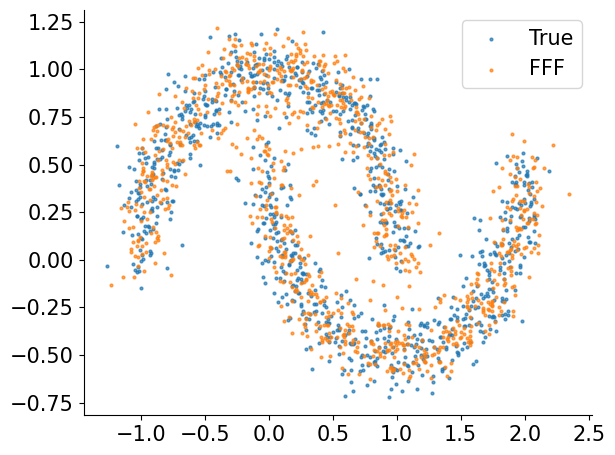

In [10]:
test_size = 1_000
test_batch, _ = make_moons(test_size, noise=noise)

plot_kwargs = dict(
    s=4,
    alpha=.7
)

plt.scatter(*test_batch.T, label="True", **plot_kwargs)

with torch.no_grad():
    plt.scatter(*sample(test_size).cpu().T, label="FFF", **plot_kwargs)
plt.legend()

In [2]:
import normflows as nf
from ciflows.flows.glow import ReshapeFlow

/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
n_chs = 3
latent_size = 8
net_hidden_layers = 2
net_hidden_dim = 128

flows = []
flows += [
    ReshapeFlow(
        shape_in=(n_chs, latent_size, latent_size),
        shape_out=(n_chs * latent_size * latent_size,),
    )
]
flows += [
    nf.flows.AutoregressiveRationalQuadraticSpline(
        num_input_channels=n_chs * latent_size * latent_size,
        num_blocks=net_hidden_layers,
        num_hidden_channels=net_hidden_dim,
        permute_mask=True,
    )
]


q0 = nf.distributions.DiagGaussian(
        (n_chs, latent_size, latent_size), trainable=False
    )
model = nf.NormalizingFlow(q0=q0, flows=flows)

samples, log_det = model.sample(2)
print(samples.shape, log_det)

torch.Size([2, 192]) tensor([-281.7713, -273.2248], grad_fn=<SubBackward0>)
